# Задание

# Ход работы

## Импортируем библиотеки

In [37]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import pprint
import math
import random
import matplotlib.pyplot as plt


## Загружаем данные

In [33]:
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 

print(X.describe())

       cap-shape cap-surface cap-color bruises  odor gill-attachment  \
count       8124        8124      8124    8124  8124            8124   
unique         6           4        10       2     9               2   
top            x           y         n       f     n               f   
freq        3656        3244      2284    4748  3528            7914   

       gill-spacing gill-size gill-color stalk-shape  ...  \
count          8124      8124       8124        8124  ...   
unique            2         2         12           2  ...   
top               c         b          b           t  ...   
freq           6812      5612       1728        4608  ...   

       stalk-surface-below-ring stalk-color-above-ring stalk-color-below-ring  \
count                      8124                   8124                   8124   
unique                        4                      9                      9   
top                           s                      w                      w   
freq     

## Проверка пропущенных значений
Замечаем, что null значения есть только в столбце 'stalk-root'. Заменим их на "Unknown"

In [3]:
missing_values = X.isnull().sum()
print("Missing values per column:", missing_values, sep="\n")
X.loc[:, 'stalk-root'] = X['stalk-root'].fillna("Unknown")

Missing values per column:
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64


## Дерево решений

In [4]:
class DecisionTree:
    def __init__(self, X, y):
        self.tree = None
        self.X = X
        self.y = y
        self.fit()
    
    # построение дерева
    def fit(self):
        data = pd.concat([self.X, self.y], axis=1)
        target_name = self.y.columns[0]  
        self.tree = self.build_tree(data, target_name)
        
    # прогнозирование для набора данных
    def predict(self, X):
        predictions = []
        for _, row in X.iterrows():
            predictions.append(self.classify(row, self.tree))
        return np.array(predictions)
    
    # расчёт энтропии
    def entropy(self, target_col):
        values, counts = np.unique(target_col, return_counts=True)
        probabilities = counts / len(target_col)
        entropy = -sum(probabilities * np.log2(probabilities))
        return entropy
    
    
    # расчёт прироста информации
    def information_gain(self, data, feature, target_name='target'):
        total_entropy = self.entropy(data[target_name])
        values, counts = np.unique(data[feature], return_counts=True)
        weighted_entropy = sum((counts[i] / len(data)) * self.entropy(data[data[feature] == values[i]][target_name]) for i in range(len(values)))
        info_gain = total_entropy - weighted_entropy
        return info_gain
    
    
    # расчёт информации о разделении
    def split_info(self, data, feature):
        values, counts = np.unique(data[feature], return_counts=True)
        probabilities = counts / len(data)
        split_info = -sum(probabilities * np.log2(probabilities))
        return split_info
    
    
    # расчёт отношения прироста информации 
    def gain_ratio(self, data, feature, target_name='target'):
        info_gain = self.information_gain(data, feature, target_name)
        split_info = self.split_info(data, feature)
        return info_gain / split_info if split_info != 0 else 0
    
    
    # рекурсивное построение дерева решений
    def build_tree(self, data, target_name='target', features=None):
        
        if features is None:
            features = data.columns.drop(target_name)        
            
        # Базовые случаи
        if len(np.unique(data[target_name])) == 1:  # Один класс
            return np.unique(data[target_name])[0]
        if len(features) == 0:  # Нет признаков для разделения
            return data[target_name].mode()[0]
        
        # Выбор лучшего признака
        gain_ratios = {feature: self.gain_ratio(data, feature, target_name) for feature in features}
        best_feature = max(gain_ratios, key=gain_ratios.get)
    
        # Создание узла дерева
        tree = {best_feature: {}}
        for value in np.unique(data[best_feature]):
            subset = data[data[best_feature] == value]
            subtree = self.build_tree(subset, target_name, features.drop(best_feature))
            tree[best_feature][value] = subtree

        return tree
    
    # рекурсивная классификация на основе дерева решений
    def classify(self, row, tree):
        if not isinstance(tree, dict):
            return tree
        feature = list(tree.keys())[0]
        subtree = tree[feature].get(row[feature], None)
        if subtree is None:  # Нет значения в обучающей выборке
            return None
        return self.classify(row, subtree)


## Разделение данных
Поделим данные в соотношении 80% для обучения, 20% для тестов.
Предварительно перемешаем их, а потом выберем sqrt(n) случайных признаков для построения дерева.

In [5]:
def split_data(X, y, test_size=0.2):
    data = pd.concat([X, y], axis=1)
    shuffled_data = data.sample(frac=1).reset_index(drop=True)
    train_size = int(data.shape[0] * (1 - test_size))
    shuffled_X, shuffled_y = shuffled_data[shuffled_data.columns.drop(y.columns)], shuffled_data[y.columns]
    X_train, X_test = shuffled_X[:train_size], shuffled_X[train_size:]
    y_train, y_test = shuffled_y[:train_size], shuffled_y[train_size:]
    
    return X_train, X_test, y_train, y_test
    

X_train, X_test, y_train, y_test = split_data(X, y)

def get_random_columns(X_train, X_test, random_state=2):
    n = X_train.shape[1]
    random.seed =random_state
    random_columns = random.choices(X_train.columns, k=round(math.sqrt(n)))
    X_train_random, X_test_random = X_train[random_columns], X_test[random_columns]
    
    return X_train_random, X_test_random

X_train_random, X_test_random = get_random_columns(X_train, X_test)


## Функции оценки метрик

In [43]:
def calculate_metrics(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    
    # Вычисляем метрики
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    fpr = FP / (FP + TN) if (FP + TN) > 0 else 0
    
    return accuracy, precision, recall, fpr



## Проверка работы

{'bruises': {'f': {'veil-color': {'n': 'e',
                                  'o': 'e',
                                  'w': {'habitat': {'d': {'cap-surface': {'f': 'p',
                                                                          's': {'stalk-color-above-ring': {'n': 'e',
                                                                                                           'p': 'p',
                                                                                                           'w': 'p'}},
                                                                          'y': {'stalk-color-above-ring': {'b': 'p',
                                                                                                           'c': 'p',
                                                                                                           'n': 'p',
                                                                                                           'p': 'p',
       

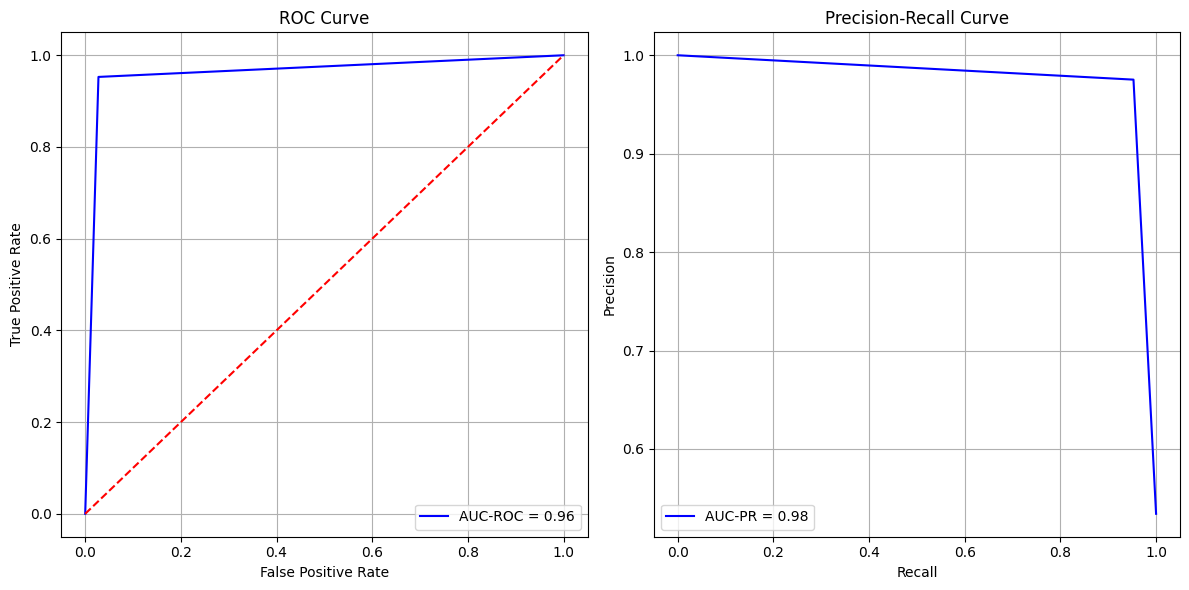

ROC AUC: 0.963
PR AUC: 0.977


In [45]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score


tree = DecisionTree(X_train_random, y_train)
pprint.pprint(tree.tree)

predictions = tree.predict(X_test_random)

y_true_bin = np.where(y_test['poisonous'] == 'e', 1, 0)
y_pred_bin = np.where(predictions == 'e', 1, 0)

accuracy, precision, recall, fpr = calculate_metrics(y_true_bin, y_pred_bin)

# Вывод результатов
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"False Positive Rate (FPR): {fpr:.3f}")


precision, recall, _ = precision_recall_curve(y_true_bin, y_pred_bin)
pr_auc = auc(recall, precision)

fpr, tpr, _ = roc_curve(y_true_bin, y_pred_bin)
roc_auc = auc(fpr, tpr)

# Вычисляем Precision и Recall для PR
precision, recall, _ = precision_recall_curve(y_true_bin, y_pred_bin)
pr_auc = auc(recall, precision)

# Параметры графиков
plt.figure(figsize=(12, 6))


# График AUC-ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', label=f'AUC-ROC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # линия случайного классификатора
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()

# График AUC-PR
plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', label=f'AUC-PR = {pr_auc:.2f}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.grid()

# Показать графики
plt.tight_layout()
plt.show()

print(f"ROC AUC: {roc_auc:.3f}")
print(f"PR AUC: {pr_auc:.3f}")
